# A COVID-19 Lockdown Visualisation
Yesterday a pal of mine tweeted the following BBC graph. It shows the type of lockdowns for European countries over time. I thought it was a very effective visualisation. It conveys a lot of imformation very efficiently, and in a manner that works well visually.

For example, the extent to which different countries have implemented various lockdown measures, is conveyed well, from weak localised recommendations to more restrictive national rules using the colour of the bars. The starting point and length of each stack of bars tells us when various measures were implemented, and for how long, and changing colours signal changing measures. The first-case 'line graph' tells us when each country's COVID-19 otbreak began - the date of their first case - and the distance between the date of the first case and the start of each stack signals how quickly a country responded to the crisis.

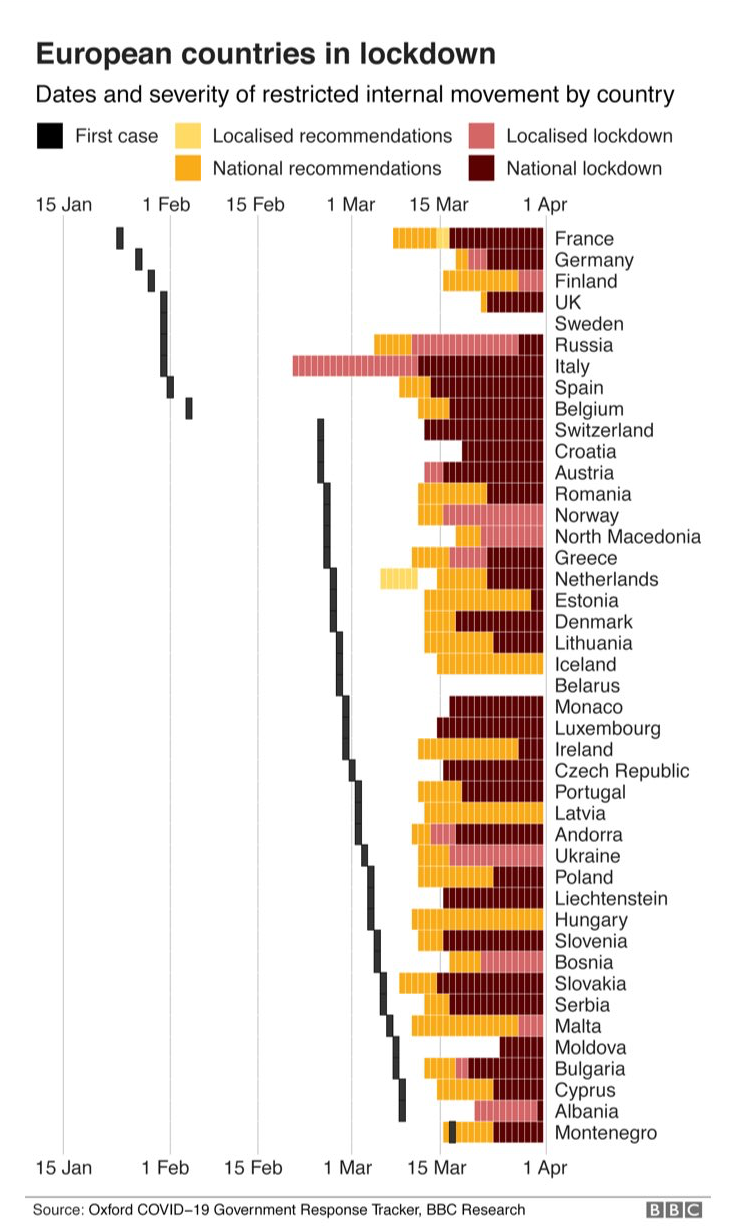

In [2]:
from IPython.display import Image
Image("../images/bbc_lockdown_graph.png", width=400)

So I started thinking ... how might this be implemented? What type of chart is it? It's clearly two charts: some sort of stacked bar chart to convey the degree of the lockdown measures and some sort of line graph to show the date of the first cases.

In fact both of these intuitions are wrong – or at least they turned out not to be helpful in terms of my implementation efforts. After a bit iof experimentation it occurred to me that in fact the best way to implement this chart was as two customised heatmaps. The purpose of this post is to discuss how I did this.

In [3]:
from datetime import date

import pandas as pd
import numpy as np

from matplotlib.pylab import plt
import matplotlib.dates as mdates

import seaborn as sns

import requests
import json

sns.set_style("white")

sns.set_context("paper")
dpi = 200
figsize=(15, 6)


%matplotlib inline

# The Oxford COVID-19 Government Response Tracker
One issue with reproducing the BBC graph is that I don't have the lockdown dataset that they used, and while I could copy it down from the graph, that's not what I did. Instead I happened upon the [Oxford COVID-19 tracker](https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker), which aims to:

>"aims to track and compare government responses to the coronavirus outbreak worldwide rigorously and consistently."

What this means is that they are doing the hard work of collecting and classifying the various different measures that have been used by governments around the world and turning them into a simple _Stringency Index_ (SI). The SI is a simple additive score of the seven different lockdown indicators, rescaled to a value from 0 to 100. Bear in mind that the measure is for comparative purposes only, and it should not  be used as a rating of the appropriateness or effectiveness of a country's response. However, it is suitable for our purposes here.

So, in what follows, we collect data from the tracker API to produce a dataframe that maps SI valeus to countries and dates.

In [4]:
date_range_endpoint = 'https://covidtrackerapi.bsg.ox.ac.uk/api/stringency/date-range/{from_date}/{to_date}'
from_date, today = '2020-01-01', date.today().strftime('%Y-%m-%d')

## Downloading the datatset

In [5]:
# The data we want is in a big json object under the 
r = requests.get(date_range_endpoint.format(from_date=from_date, to_date=today))
r

<Response [200]>

In [6]:
# The data we want ...
data = r.json()['data']
data['2020-04-11']['IRL']  # One of the basic records

{'date_value': '2020-04-11',
 'country_code': 'IRL',
 'confirmed': 8089,
 'deaths': 287,
 'stringency_actual': 91.8,
 'stringency': 91.8,
 'stringency_legacy': 91.43,
 'stringency_legacy_disp': 91.43}

In [7]:
# Turn this into a dataframe indexed by date and country code; this is a bit fiddly but
# does the job.
df = pd.concat({k: pd.DataFrame(v).T for k, v in r.json()['data'].items()}, axis=0)
df.sample(3)

,,confirmed,country_code,date_value,deaths,stringency,stringency_actual,stringency_legacy,stringency_legacy_disp
2020-03-26,DEU,36508,DEU,2020-03-26,198,74.61,74.61,70.95,70.95
2020-01-01,LUX,0,LUX,2020-01-01,0,0,0,0,0
2020-05-01,MEX,19224,MEX,2020-05-01,1859,85.45,85.45,84.76,84.76


In [8]:
# Some cleanup - change the column names and drop some duplicated columns
# after the conversion to a df. Also change the date to a datetime data type.
df.reset_index(inplace=True)
df.drop(columns=['level_0', 'level_1'], inplace=True)
df.columns = ['cases', 'country', 'date', 'deaths', 'stringency', 'stringency_actual', 'stringency_legacy', 'stringency_legacy_disp']

df = df[['date', 'country', 'cases', 'deaths', 'stringency', 'stringency_actual']]

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df.sample(3)


,country,cases,deaths,stringency,stringency_actual
date,,,,,
2020-02-21,KAZ,None,None,0,0
2020-05-16,POL,18016,907,88.09,None
2020-01-03,BMU,None,None,0,0


In [9]:
# Next we can calculate the number of days form a given date to the date of the kth case/death
df = df.reset_index().set_index('country')

# For various reasons it is going to be easier to create our graph by plotting 
# against an x-axis that is measuring an integer number of days since the first
# date in the dataset. Let's add this as a new column.
df['day'] = (df['date']-pd.to_datetime(df['date']).min()).map(lambda days: days.days)

df.shape


(22139, 6)

## Assiging SI Levels
For convenience I'm assigning specific SI levels to various ranges of raw SI values. This provides a greater level of control over the assignment of SI values to heatmap colours/categories.

In [10]:
# The SI levels
low_si = (df['stringency']>20) & (df['stringency']<=50)
med_si = (df['stringency']>50) & (df['stringency']<=65)
high_si = (df['stringency']>65) & (df['stringency']<=80)
vhigh_si = (df['stringency']>80)


df['si_level'] = np.where(low_si, 1, np.nan)
df['si_level'] = np.where(med_si, 2, df['si_level'])
df['si_level'] = np.where(high_si, 3, df['si_level'])
df['si_level'] = np.where(vhigh_si, 4, df['si_level'])

df.groupby('si_level').size()

si_level
1.0    1644
2.0    1598
3.0    2191
4.0    5527
dtype: int64

# Reproducing the BBC Graph

## The date/day of the first confirmed cases
For each country we need to know the date (and day number) when it confirmed its first cases; this is th ebasic data needed for the first cases part of the chart but it's also used to sort the countries in order of their first case occurrences.

In [11]:
# We need to sort our dataframe by the date of the first cases in a country.
# The easiest way to do this is to add a column with date of the first cases for
# each country so that we can sort by this column.

first_case_date_by_country = pd.DataFrame(df.groupby('country').apply(
    lambda g: g[g['cases']>0]['date'].min()), columns=['first_case_date']
)

# Add these first cases dates to the main DF and sort it.
df = df.join(first_case_date_by_country).sort_values(by='first_case_date')

# And let's add corresponding day column -- the day number for the first case -- since
# we are using day numbers in our graph.
df['first_case_day'] = (df['date']-pd.to_datetime(df['first_case_date'], infer_datetime_format=True)).map(lambda td: td.days)

df.sample(3)

,date,cases,deaths,stringency,stringency_actual,day,si_level,first_case_date,first_case_day
country,,,,,,,,,
QAT,2020-02-08,0,0,15.47,15.47,38,NaN,2020-03-01,-22.0
MNG,2020-01-11,None,None,11.11,11.11,10,NaN,2020-03-10,-59.0
KOR,2020-03-12,7869,66,58.46,58.46,71,2.0,2020-01-20,52.0


In [12]:
# The countries to use in our graph.

use_countries = [
    'USA', 'FRA', 'DEU', 'FIN', 'GBR', 'SWE', 'RUS', 'ITA', 'ESP', 'BEL', 'CHE', 'HRV', 'AUT', 'ROU', 'NOR', 
    'GRC', 'NLD', 'ISL', 'LUX', 'IRL', 'PRT', 'UKR', 'POL', 'HUN', 'SVN', 'SVK', 'SRB', 'BGR',

]


## Plotting the Graph
The graph is produced using two modified (Seaborn) heatmaps:

* The first one plots the stringency index values, by days, for each country, colour coded based on the SI value;
* The second plots the day of the first cases for each country on a duplicated axis.

After that it is just a matter of getting the look and feel correct in terms of axes tick labels and the stringency index legend.

### The colourmap
We are going to use 4 discrere colour to display the SI heatmap.

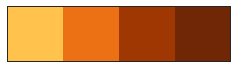

In [13]:
stringency_palette = sns.color_palette("YlOrBr", 41)

stringency_cmap = [stringency_palette[15], stringency_palette[25], stringency_palette[35], stringency_palette[40]]
sns.palplot(stringency_cmap)

### The x-axis tick labels
The x-axis is in day numbers (from 1/1/2020) and we want to convert this to more meaningful date strings. We could use some Matplotlib date formatters for this, but to be honest this turned out to be quite messy and didn't go as planned. So instead I just convert the dates (which correspond to a the day numbers) into more concise date representations using a 3-letter month name and an interger date number, based on a given date interval to skip-count the days; in line with the BBC graph we use a 14-day interval.

In [18]:
# The x-axis dates, every 124 days

date_interval = 14

df['date'].unique()[::date_interval]

array(['2020-03-10T00:00:00.000000000', '2020-02-21T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-03-04T00:00:00.000000000',
       '2020-01-21T00:00:00.000000000', '2020-04-18T00:00:00.000000000',
       '2020-05-02T00:00:00.000000000', '2020-03-17T00:00:00.000000000',
       '2020-03-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
# Now generate the date labels from these dates, by combining the month name and the day.
date_labels = [
    '{} {}'.format(pd.to_datetime(d).month_name()[:3], str(pd.to_datetime(d).day)) 
    for d in sorted(df['date'].unique())[::date_interval]
]

date_labels

['Jan 1',
 'Jan 15',
 'Jan 29',
 'Feb 12',
 'Feb 26',
 'Mar 11',
 'Mar 25',
 'Apr 8',
 'Apr 22']

### The Stringency Index dataframe
We need to prepare a dataframe of SI levels so that they can be turned into a heatmap. This requires a  dataframe whose rows are countries and whose columns are day numbers. Then the value of each cell is the SI value. We only consider SI values >20, replacing smaller values with NaNs so that they are not plotted.

In [20]:
stringency_for_country_by_date = df\
    .reset_index()\
    .set_index(['country', 'day'])['si_level']\
    .unstack()\
    .T.ffill().T

In [21]:
stringency_for_country_by_date.loc[['CHN', 'ITA', 'USA']]

day,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
country,,,,,,,,,,,,,,,,,,,,,
CHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
ITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### The First Cases Dataframe
For the second heatmap we need a similar datframe, but it is more sparsely populated. Once again its rows are countries and its columns are dates. But this time, each country only has data in one of its cells to indicate the date that its first confirmed cases appeared.

In [22]:
# For this heatmap want a matrix with a 1 in the cell for a country when the first case occured.
first_cases_for_country_by_date = df\
    .reset_index()\
    .set_index(['country', 'day'])['first_case_day']\
    .unstack()\
    .applymap(lambda n: 1 if n==0 else np.nan)  # We only mark the day of the first case; everything else is NaN.

In [23]:
# Just look at a subset of the cells for a few countries.
first_cases_for_country_by_date.loc[['CHN', 'ITA', 'USA', 'ESP', 'IRL']].dropna(axis=1, how='all')

day,0,20,30,31,60
country,,,,,
CHN,1.0,NaN,NaN,NaN,NaN
ITA,NaN,NaN,1.0,NaN,NaN
USA,NaN,1.0,NaN,NaN,NaN
ESP,NaN,NaN,NaN,1.0,NaN
IRL,NaN,NaN,NaN,NaN,1.0


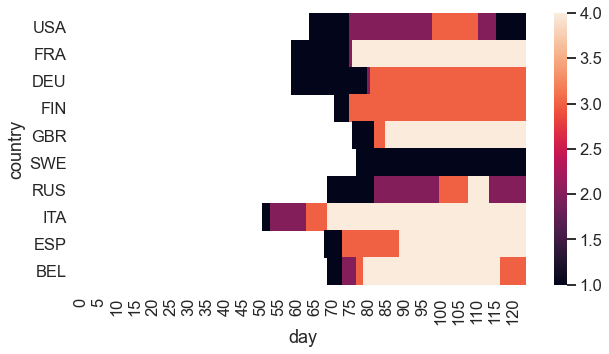

In [34]:
# Test a simple heatmap for using the SI dataframe for a sample
# of 10 countries

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10, len(use_countries[:10])*.5))

sns.heatmap(stringency_for_country_by_date.loc[use_countries[:10]], ax=ax, cbar=True)

fig.savefig('../images/simple_si_heatmap.png', format='png', dpi=300)

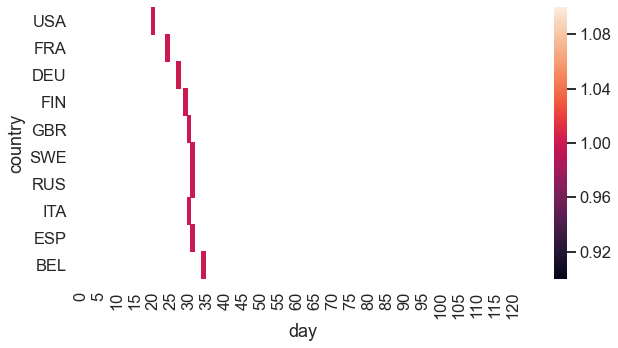

In [35]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(10, len(use_countries[:10])*.5))

sns.heatmap(first_cases_for_country_by_date.loc[use_countries[:10]], ax=ax, cbar=True)

fig.savefig('../images/first_cases_heatmap.png', format='png', dpi=300)

Text(0.0, 1.0, 'Countries in Lockdown (2020)\n')

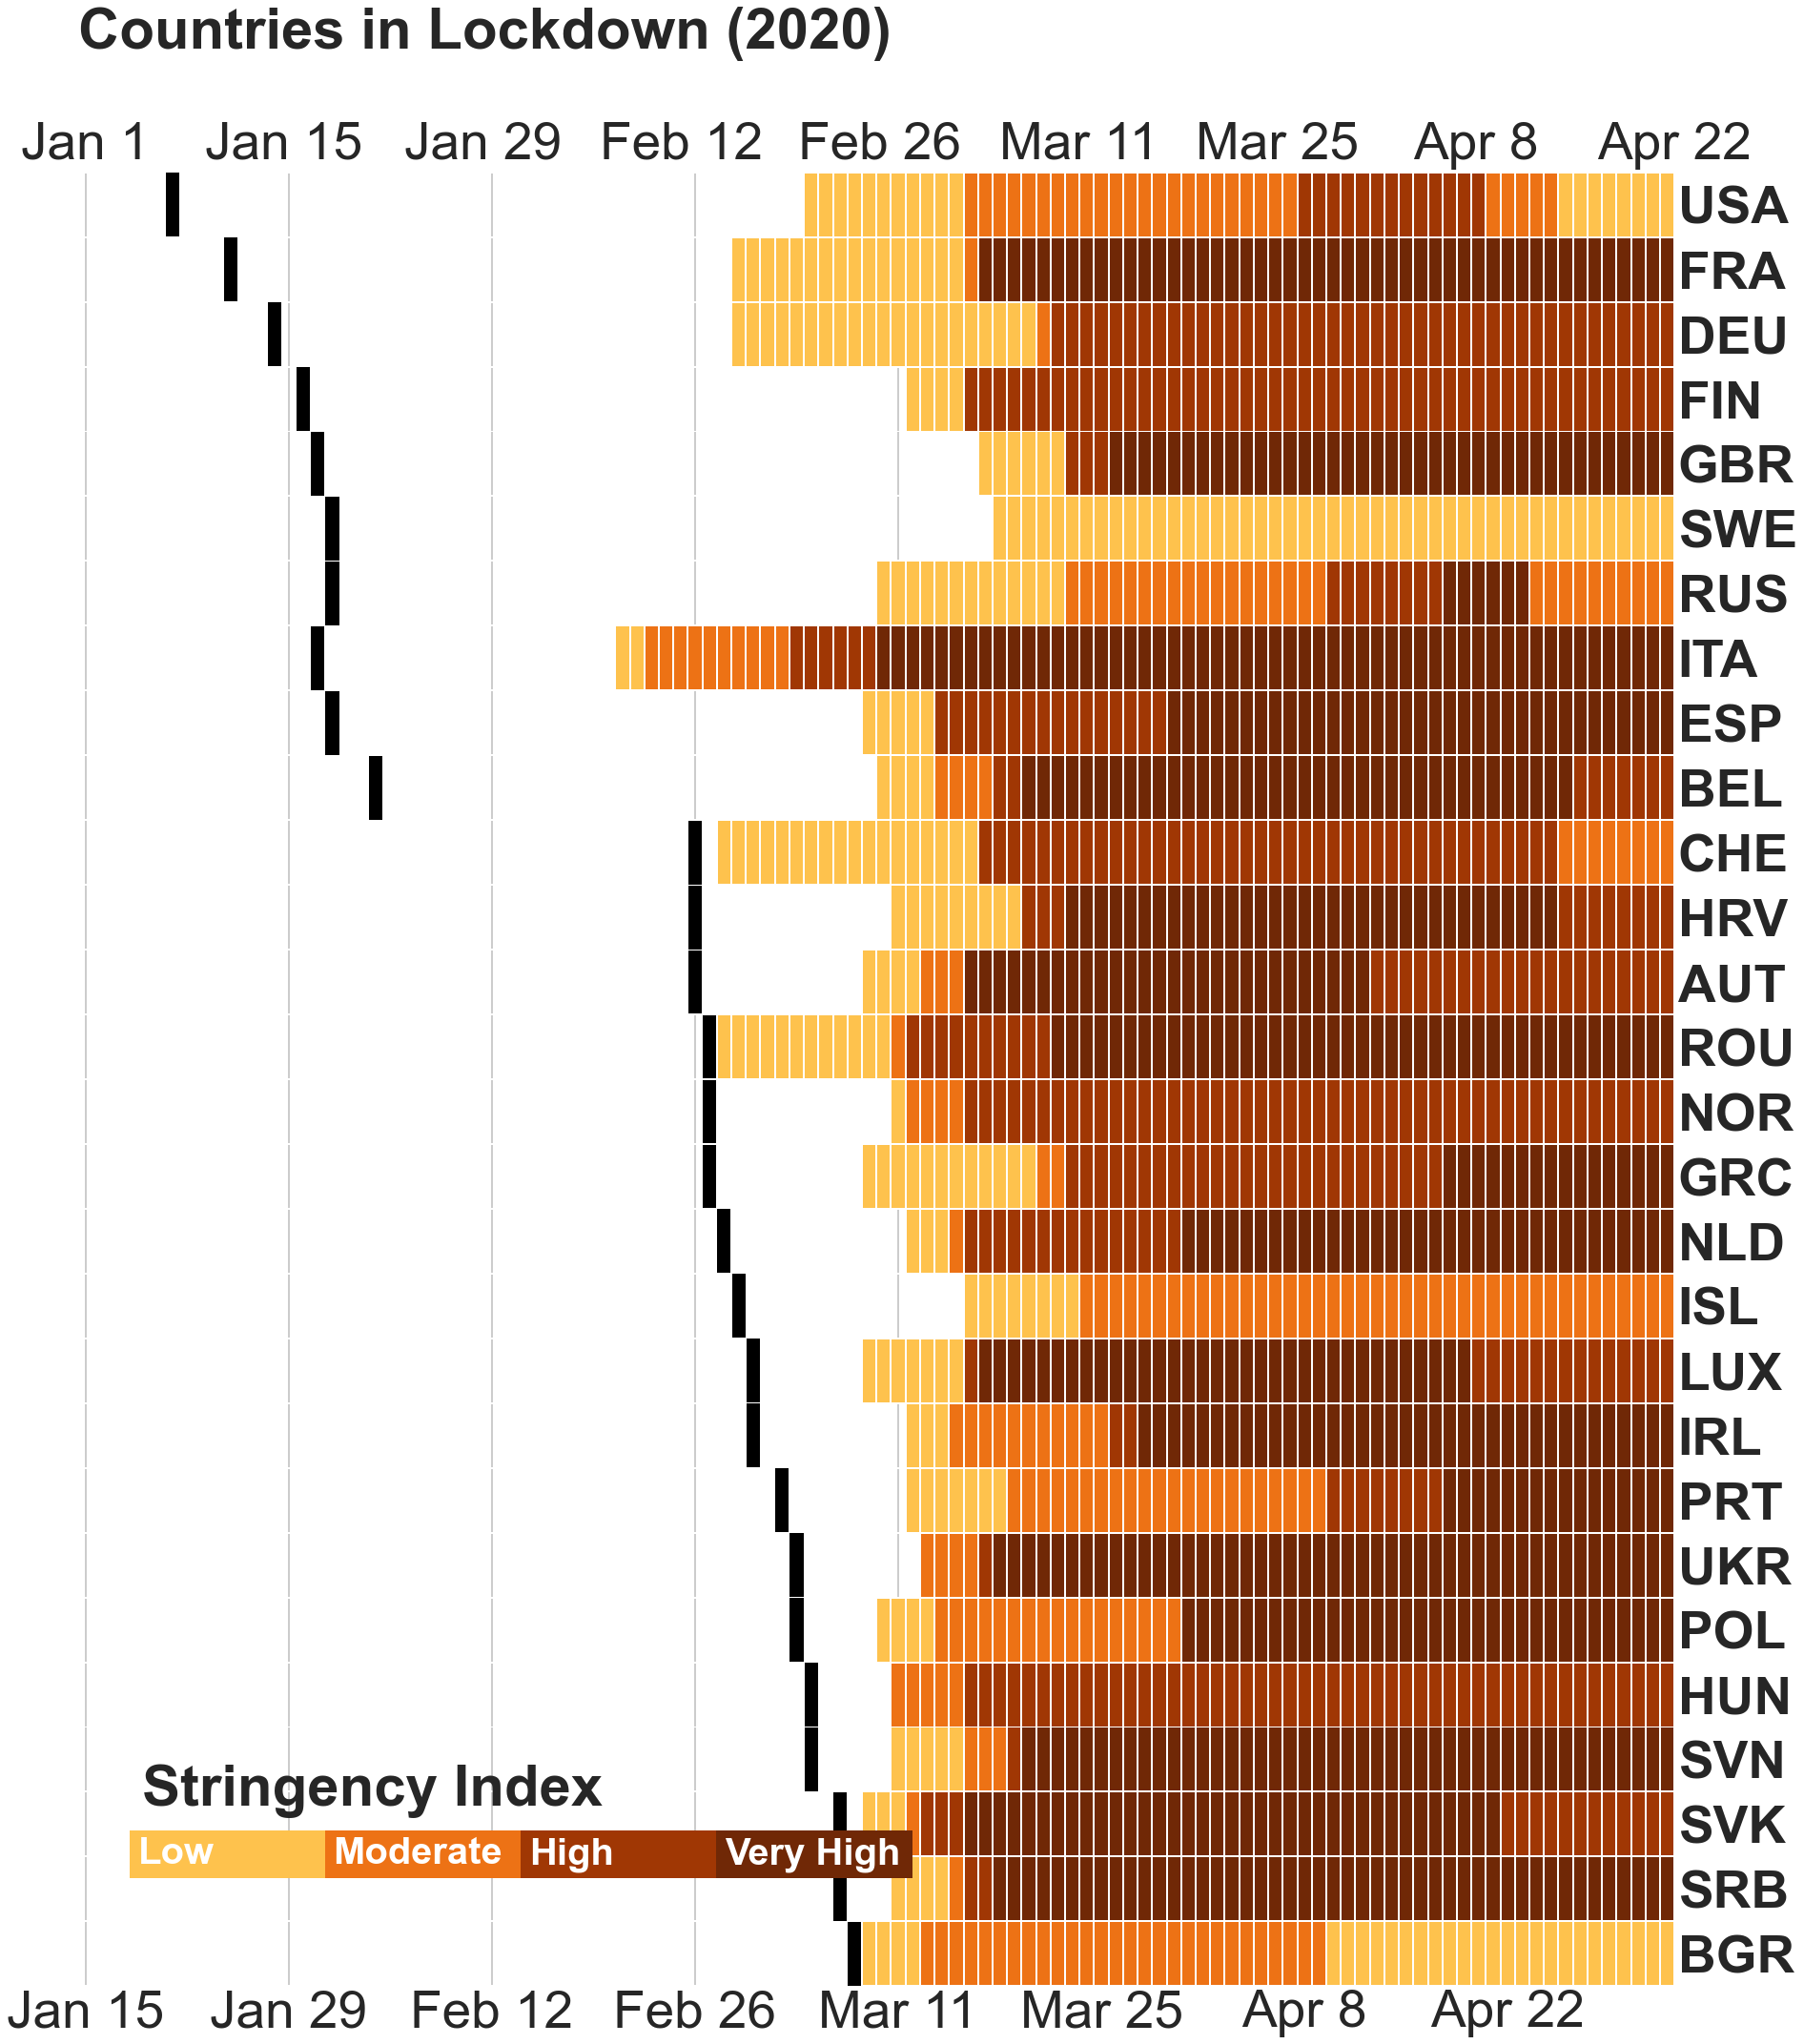

In [28]:
sns.set_context('poster', font_scale=2.5)

fig, ax = plt.subplots(figsize=(30, len(use_countries)*1.25))



# ----------------------------
# The Stringency Index Heatmap
# ----------------------------

# For maximum flexibility we use a separate axis to plot the heatmap's 
# colour bar (horizontally) as the SI legend.
cbar_ax = fig.add_axes([.15, .17, .38, 3/len(stringency_for_country_by_date)])

# The heatmap itself is straightfoward with one caveat: after much fiddling I had to
# set its xticklabels parameter to the date interval we are using.
sns.heatmap(stringency_for_country_by_date.loc[use_countries], ax=ax, 
            linewidths=1, cmap=stringency_cmap, cbar=True, xticklabels=date_interval, zorder=10, 
            cbar_ax=cbar_ax, cbar_kws=dict(orientation='horizontal', ticks=[])
           )


# ----------------------------
# The First Cases Heatmap
# ----------------------------

# The first cases plot doesn't look like a heatmap. It looks like a variation of a
# line graph, but this doesn't work. Notice that the first case markers for each country 
# are not regular matplotlib markers, they are vertical lines that align and match with the
# the SI cells.

bx = ax.twinx()  # We need a duplicate axis

# The first cases heatmap
sns.heatmap(first_cases_for_country_by_date.loc[use_countries], ax=ax, 
            linewidths=.15, cmap=['k'], cbar=False, xticklabels=14, zorder=10)


# ----------------------------
# Axes, labels &  grid-lines
# ----------------------------

ax.set_xticklabels(date_labels)

# We want a duplicate x axis on the top too.
ax2 = ax.twiny()
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(ax.get_xticklabels())

# Remove axes ticks
ax.tick_params(axis='both', length = 0)
ax2.tick_params(axis='both', length = 0)

# Draw the vertical gridlines
ax.grid(axis='x', lw=2)

# We dont need labels for the x axes.
ax.set_xlabel('')
ax.set_ylabel('')

# Shift the y axis labels to the right-hand side.
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontweight='bold')
ax.yaxis.tick_right()

# We don't need the y-axis ticks/labels for teh second y-axis.
bx.set_yticks([])
bx.set_yticklabels([])

ax.set_xlim(14)
bx.set_xlim(14)

# Remove the frame around the plot
sns.despine(left=True, bottom=True, right=True)

# A title for the SI legend.
bx.annotate('Stringency Index', xy=(.04, .1), xycoords='axes fraction', fontweight='bold')

# The SI legend category labels.
for (x, label) in zip(np.arange(0, 1, .25), ['Low', 'Moderate', 'High', 'Very High']):
    cbar_ax.annotate(
        label, xy=(x+.01, .3), 
        xycoords='axes fraction', 
        fontsize=40, fontweight='bold', color='white'
    )




# A title for the graph.
ax.set_title('Countries in Lockdown (2020)\n', fontweight='bold', loc='left')


In [29]:
fig.savefig('../images/bbc_stringency_index.png', format='png', dpi=300)